# CCA on Bot-IoT

In [39]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

In [38]:


df = pl.scan_csv(
    'Final_Merged_Dataset.csv',
    null_values=["-","NaN","nan","inf","?"],
    ignore_errors=True
    )

In [3]:
print(df)

naive plan: (run LazyFrame.explain(optimized=True) to see the optimized plan)

Csv SCAN [Final_Merged_Dataset.csv]
PROJECT */35 COLUMNS
ESTIMATED ROWS: 69940782


In [4]:
num_cols = [c for c,d in df.schema.items() if d in (pl.Int64, pl.Float64)]

cat_cols = [c for c,d in df.schema.items() if d == pl.Utf8]

/tmp/ipykernel_5228/1909559097.py:1: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  num_cols = [c for c,d in df.schema.items() if d in (pl.Int64, pl.Float64)]
/tmp/ipykernel_5228/1909559097.py:3: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  cat_cols = [c for c,d in df.schema.items() if d == pl.Utf8]


In [5]:
print(num_cols)

['pkSeqID', 'stime', 'sport', 'dport', 'pkts', 'bytes', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'attack']


In [6]:
print(cat_cols)

['flgs', 'proto', 'saddr', 'daddr', 'state', 'smac', 'dmac', 'soui', 'doui', 'sco', 'dco', 'category', 'subcategory']


In [7]:
print(len(num_cols) + len(cat_cols))

35


In [8]:
# import polars.selectors as cs

# cat_cols = df.select(cs.string()).columns

# print(cat_cols)

In [9]:
df = df.with_columns([
    pl.col(c).cast(pl.Categorical).to_physical().alias(c)
    for c in cat_cols
])

In [10]:
print(df)

naive plan: (run LazyFrame.explain(optimized=True) to see the optimized plan)

 WITH_COLUMNS:
 [col("flgs").strict_cast(Categorical).to_physical(), col("proto").strict_cast(Categorical).to_physical(), col("saddr").strict_cast(Categorical).to_physical(), col("daddr").strict_cast(Categorical).to_physical(), col("state").strict_cast(Categorical).to_physical(), col("smac").strict_cast(Categorical).to_physical(), col("dmac").strict_cast(Categorical).to_physical(), col("soui").strict_cast(Categorical).to_physical(), col("doui").strict_cast(Categorical).to_physical(), col("sco").strict_cast(Categorical).to_physical(), col("dco").strict_cast(Categorical).to_physical(), col("category").strict_cast(Categorical).to_physical(), col("subcategory").strict_cast(Categorical).to_physical()] 
  Csv SCAN [Final_Merged_Dataset.csv]
  PROJECT */35 COLUMNS
  ESTIMATED ROWS: 69940782


In [11]:
sample_df = df.limit(1000000).collect()

In [12]:
print(sample_df)

shape: (1_000_000, 35)
┌──────────┬──────────┬──────┬───────┬───┬───────┬────────┬──────────┬─────────────┐
│ pkSeqID  ┆ stime    ┆ flgs ┆ proto ┆ … ┆ drate ┆ attack ┆ category ┆ subcategory │
│ ---      ┆ ---      ┆ ---  ┆ ---   ┆   ┆ ---   ┆ ---    ┆ ---      ┆ ---         │
│ i64      ┆ f64      ┆ u32  ┆ u32   ┆   ┆ i64   ┆ i64    ┆ u32      ┆ u32         │
╞══════════╪══════════╪══════╪═══════╪═══╪═══════╪════════╪══════════╪═════════════╡
│ 73000002 ┆ 1.5281e9 ┆ 0    ┆ 4     ┆ … ┆ 0     ┆ 1      ┆ 9        ┆ 10          │
│ 73000003 ┆ 1.5281e9 ┆ 0    ┆ 4     ┆ … ┆ 0     ┆ 1      ┆ 9        ┆ 10          │
│ 73000004 ┆ 1.5281e9 ┆ 0    ┆ 4     ┆ … ┆ 0     ┆ 1      ┆ 9        ┆ 10          │
│ 73000005 ┆ 1.5281e9 ┆ 0    ┆ 4     ┆ … ┆ 0     ┆ 1      ┆ 9        ┆ 10          │
│ 73000006 ┆ 1.5281e9 ┆ 0    ┆ 4     ┆ … ┆ 0     ┆ 1      ┆ 9        ┆ 10          │
│ …        ┆ …        ┆ …    ┆ …     ┆ … ┆ …     ┆ …      ┆ …        ┆ …           │
│ 47629555 ┆ 1.5281e9 ┆ 1    ┆ 3     ┆ … ┆

In [45]:
leakage_cols = ["category", "subcategory"]
X = sample_df.drop(leakage_cols + ["attack"]).to_numpy()
y = sample_df.select('attack').to_numpy()

In [46]:
import joblib
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)
loaded_scaler = joblib.load('scaler.save')

X = loaded_scaler.fit_transform(X)
y = enc.fit_transform(y.reshape(-1,1))

/home/sathya/Major/IoT_venv/lib/python3.13/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [47]:
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

In [48]:
from sklearn.cross_decomposition import CCA

cca = CCA(n_components=2)
X_c, Y_c = cca.fit_transform(X, y)

In [49]:
importance = np.abs(cca.x_weights_).sum(axis=1)
selected_features = np.argsort(importance)[-50:]

In [50]:
print(selected_features)

[24 31 23 22 21 17 16  5 12  4 30 18 13 14 29  2  7 10 19 15 20  3 27  8
 25  9 28 26  0  6 11  1]


In [51]:
feature_names = sample_df.drop("attack").columns
selected_feature_names = [feature_names[i] for i in selected_features]
selected_importance = importance[selected_features]

vis_df = pl.DataFrame({
    "feature":selected_feature_names,
    "importance": selected_importance
}).sort("importance",descending=False)

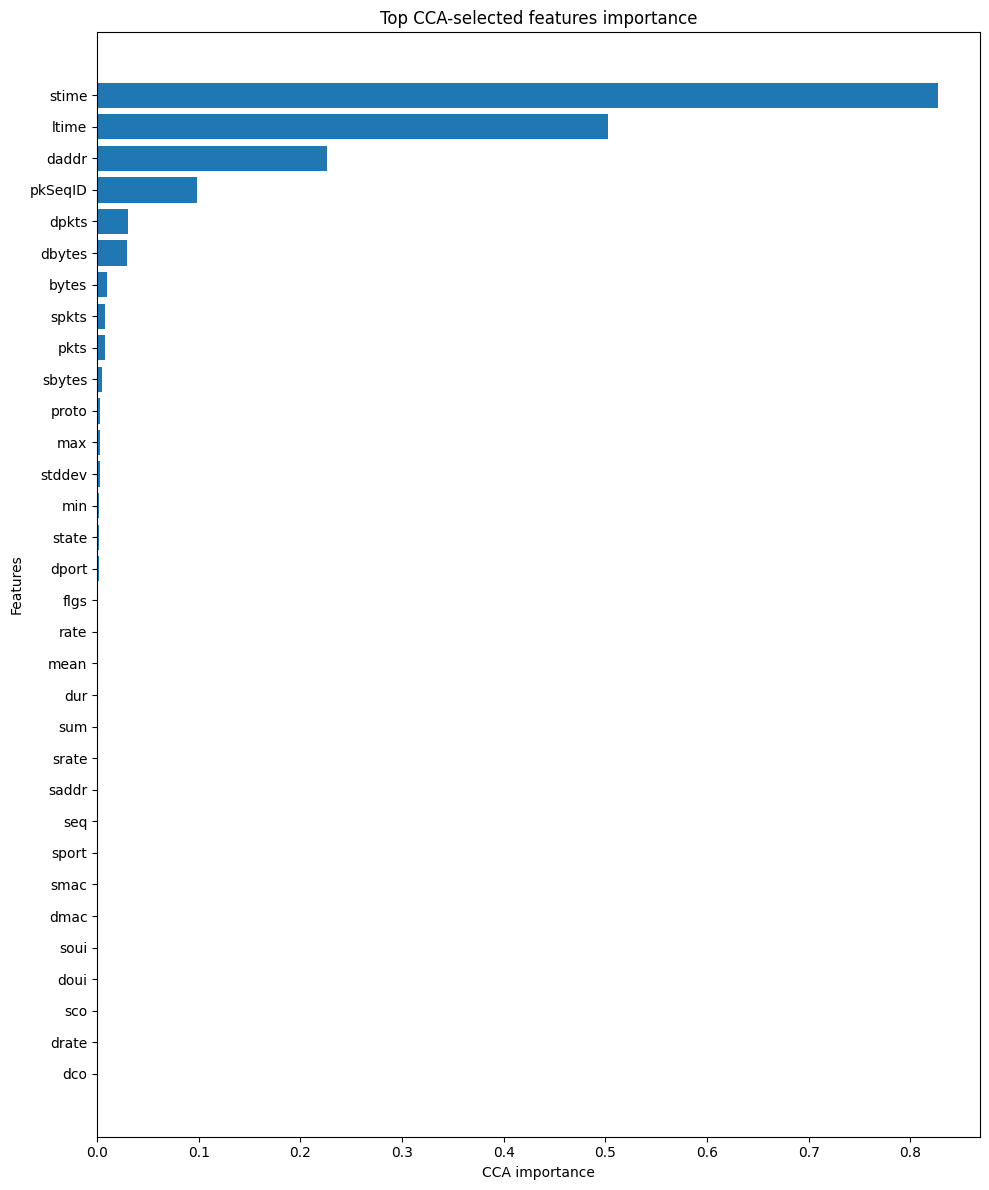

In [52]:
plt.figure(figsize=(10,12))
plt.barh(vis_df["feature"], vis_df["importance"])
plt.xlabel("CCA importance")
plt.ylabel("Features")
plt.title("Top CCA-selected features importance")
plt.tight_layout()
plt.show()

In [53]:
selected_idx = np.where(importance>0.01)[0]

In [54]:
new_features = [feature_names[i] for i in selected_idx]